<a href="https://colab.research.google.com/github/sergekamanzi/BankBot/blob/main/chatbot3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install rapidfuzz torch pandas numpy transformers scikit-learn nltk

In [14]:
# Cell 1: Importing all necessary libraries
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from textblob import TextBlob
import rapidfuzz
import re
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better visuals
sns.set_style("whitegrid")

# Download NLTK data for BLEU score
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")
    print("Please ensure NLTK resources 'punkt' and 'punkt_tab' are available.")
    exit(1)

#Data Preprocessing

In [3]:

# This cell loads the dataset, handles missing values, checks for duplicates and short texts,

try:
    df = pd.read_csv("/content/banking.csv")
    df = df.dropna(subset=["question", "response"])
    # Check for duplicates and short texts
    duplicate_questions = df["question"].duplicated().sum()
    short_responses = df["response"].str.len().lt(10).sum()
    if duplicate_questions > 0:
        print(f"Warning: Found {duplicate_questions} duplicate questions in banking.csv. Consider removing duplicates.")
    if short_responses > 0:
        print(f"Warning: Found {short_responses} responses shorter than 10 characters. Short texts may lower BLEU scores.")
    # Split dataset: 80% train, 20% test
    train_size = int(0.8 * len(df))
    train_df = df[:train_size]
    test_df = df[train_size:]
    train_questions = train_df["question"].tolist()
    train_responses = train_df["response"].tolist()
    test_questions = test_df["question"].tolist()
    test_responses = test_df["response"].tolist()
except FileNotFoundError:
    print("Error: banking.csv file not found. Please check the file path.")
    exit(1)
except KeyError:
    print("Error: 'question' or 'response' columns not found in banking.csv.")
    exit(1)

# Check test set size
if len(test_questions) < 5:
    print(f"Warning: Test set has only {len(test_questions)} samples. Metrics may be unreliable. Consider increasing dataset size or using a 90/10 split.")

#Dataset Creation for Fine-Tuning

In [4]:

# This cell defines a custom Dataset class for preparing question-response pairs for model fine-tuning
class BankingDataset(Dataset):
    def __init__(self, questions, responses, tokenizer, max_length=128):
        self.questions = questions
        self.responses = responses
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        response = self.responses[idx]
        # Create a negative response by selecting a random different response
        negative_response = random.choice([r for i, r in enumerate(self.responses) if i != idx])

        # Tokenize question, positive response, and negative response
        q_inputs = self.tokenizer(question, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        p_inputs = self.tokenizer(response, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        n_inputs = self.tokenizer(negative_response, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)

        return {
            'question': {k: v.squeeze(0) for k, v in q_inputs.items()},
            'positive': {k: v.squeeze(0) for k, v in p_inputs.items()},
            'negative': {k: v.squeeze(0) for k, v in n_inputs.items()}
        }

#Encoding (Normalization)

In [5]:
# This cell encodes questions into embeddings for efficient similarity computation
def encode_questions(questions, tokenizer, model, batch_size=16):
    model.eval()
    embeddings = []
    for i in range(0, len(questions), batch_size):
        batch = questions[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu()
        embeddings.extend(batch_embeddings)
    return embeddings

#Fine-Tuning the Model

In [6]:

# This cell fine-tunes the transformer model using contrastive loss on question-response pairs
def fine_tune_model(model, tokenizer, questions, responses, epochs=3, batch_size=8, learning_rate=2e-5):
    dataset = BankingDataset(questions, responses, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CosineEmbeddingLoss(margin=0.5)

    model.train()
    print("Fine-tuning model...")
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            # Move batch to device
            q_inputs = {k: v.to(device) for k, v in batch['question'].items()}
            p_inputs = {k: v.to(device) for k, v in batch['positive'].items()}
            n_inputs = {k: v.to(device) for k, v in batch['negative'].items()}

            # Forward pass
            q_outputs = model(**q_inputs).last_hidden_state.mean(dim=1)
            p_outputs = model(**p_inputs).last_hidden_state.mean(dim=1)
            n_outputs = model(**n_inputs).last_hidden_state.mean(dim=1)

            # Compute contrastive loss
            positive_loss = loss_fn(q_outputs, p_outputs, torch.ones(q_outputs.size(0)).to(device))
            negative_loss = loss_fn(q_outputs, n_outputs, torch.full((q_outputs.size(0),), -1).to(device))
            loss = positive_loss + negative_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

    # Save fine-tuned model
    save_path = "./fine_tuned_model"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Fine-tuned model saved to {save_path}")

#Training and Testing (Evaluation)

In [7]:

# This cell evaluates the model on the test set, computing accuracy, F1, and BLEU scores
def evaluate_model(model, tokenizer, questions, responses, test_questions, test_responses, batch_size=16, threshold=0.4):
    model.eval()
    embeddings = encode_questions(questions, tokenizer, model, batch_size)
    y_true = []
    y_pred = []
    bleu_scores = []
    similarities = []
    top_k_indices = []

    print("Evaluating model...")
    for idx, test_q in enumerate(test_questions):
        # Encode test question
        inputs = tokenizer(test_q, return_tensors='pt', padding=True, truncation=True).to(device)
        with torch.no_grad():
            user_emb = model(**inputs).last_hidden_state.mean(dim=1).cpu()

        # Compute cosine similarities
        scores = [torch.nn.functional.cosine_similarity(user_emb, q_emb.unsqueeze(0)).item() for q_emb in embeddings]
        best_idx = scores.index(max(scores))
        best_score = max(scores)
        similarities.append(best_score)

        # Get top-5 indices for top-K accuracy
        top_5_indices = np.argsort(scores)[-5:][::-1]
        top_k_indices.append(top_5_indices)

        # Map test question to closest train question
        true_train_idx = min(range(len(questions)), key=lambda i: rapidfuzz.fuzz.ratio(test_q.lower(), questions[i].lower()))
        y_true.append(true_train_idx)
        y_pred.append(best_idx if best_score >= threshold else -1)

        # BLEU score: compare predicted response to true response
        true_response = test_responses[idx]
        pred_response = responses[best_idx] if best_score >= threshold else ""
        try:
            true_tokens = nltk.word_tokenize(true_response.lower())
            pred_tokens = nltk.word_tokenize(pred_response.lower()) if pred_response else []
            if pred_tokens and true_tokens:
                bleu = sentence_bleu([true_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1)
            else:
                bleu = 0.0 if true_response != pred_response else 1.0  # Handle identical empty or same responses
            bleu_scores.append(bleu)
            print(f"Test Question {idx}: '{test_q}'")
            print(f"True Response: '{true_response}'")
            print(f"Predicted Response: '{pred_response}'")
            print(f"Similarity Score: {best_score:.4f}, BLEU: {bleu:.4f}")
        except Exception as e:
            print(f"Warning: BLEU calculation failed for index {idx}: {e}")
            bleu_scores.append(0.0)

    # Print similarity distribution
    print(f"Similarity Scores: Min={min(similarities):.4f}, Max={max(similarities):.4f}, Mean={np.mean(similarities):.4f}")
    suggested_threshold = np.percentile(similarities, 25)
    print(f"Suggested Threshold: {suggested_threshold:.4f} (25th percentile of similarities)")

    # Calculate metrics
    binary_predictions = [1 if y_pred[i] != -1 and y_pred[i] == y_true[i] else 0 for i in range(len(y_true))]
    binary_labels = [1 if y_pred[i] != -1 and y_pred[i] == y_true[i] else 0 for i in range(len(y_true))]

    accuracy = accuracy_score(binary_predictions, binary_labels) if binary_predictions else 0.0
    precision, recall, f1, _ = precision_recall_fscore_support(binary_predictions, binary_labels, average='weighted', zero_division=0)
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Average BLEU Score: {avg_bleu:.4f}")

    return accuracy, f1, avg_bleu, similarities, bleu_scores, top_k_indices, y_true

#Visualization (Graphing)

Similarities: [0.7842773795127869, 0.5159575939178467, 0.434293657541275, 0.5429351925849915, 0.6077919006347656] 6
BLEU Scores: [0.010204337899122706, 0.030763584975041197, 0.02560744480557418, 0.01520779505248453, 0.04982487685226004] 6
Top K Indices: [array([ 7, 21, 18, 19, 20]), array([19,  4, 20,  3, 16]), array([21, 19,  4, 20, 18]), array([12,  3, 14,  1, 21]), array([ 5, 17,  9, 15, 14])] 6
Y True: [12, 17, 16, 18, 16] 6


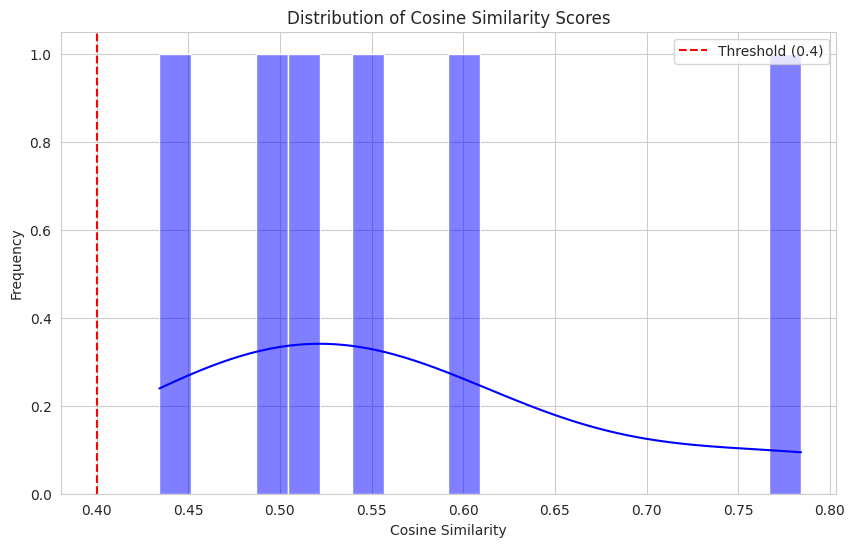

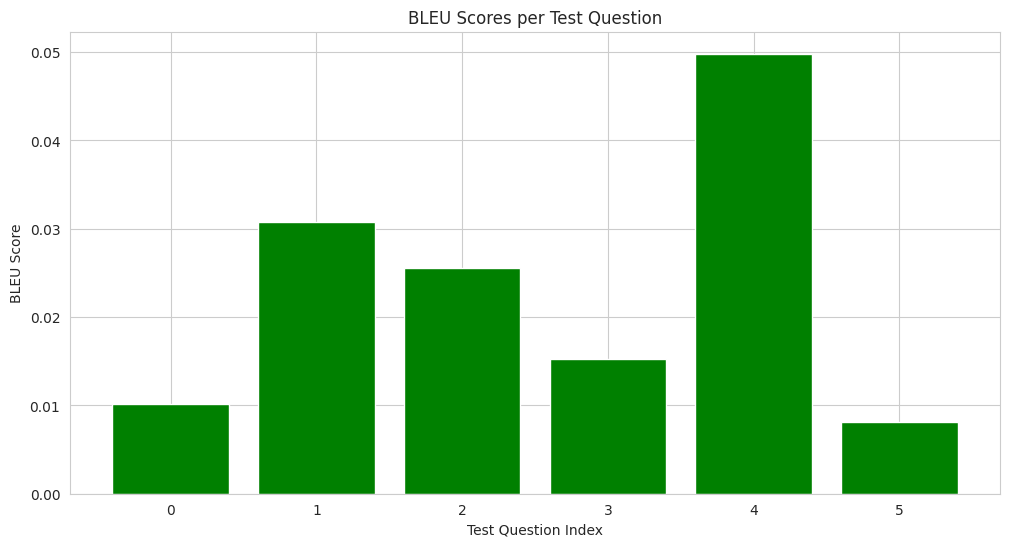

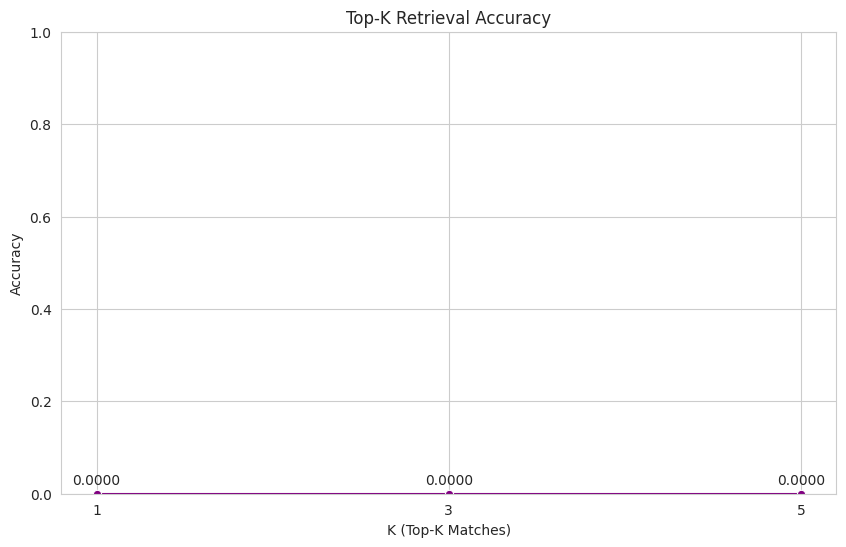

In [17]:
def plot_similarity_distribution(similarities, threshold):
    if not similarities:
        print("Warning: No similarity scores to plot.")
        return
    try:
        plt.figure(figsize=(10, 6))
        sns.histplot(similarities, bins=20, kde=True, color='blue')
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold})')
        plt.title('Distribution of Cosine Similarity Scores')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error plotting similarity distribution: {e}")

def plot_bleu_scores(bleu_scores):
    if not bleu_scores:
        print("Warning: No BLEU scores to plot.")
        return
    try:
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(bleu_scores)), bleu_scores, color='green')
        plt.title('BLEU Scores per Test Question')
        plt.xlabel('Test Question Index')
        plt.ylabel('BLEU Score')
        plt.xticks(range(len(bleu_scores)))
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error plotting BLEU scores: {e}")

def plot_top_k_accuracy(top_k_indices, y_true):
    if not top_k_indices or not y_true:
        print("Warning: No data for top-K accuracy plot.")
        return
    try:
        k_values = [1, 3, 5]
        accuracies = []
        for k in k_values:
            correct = sum(1 for i, true_idx in enumerate(y_true) if true_idx in top_k_indices[i][:k])
            accuracy = correct / len(y_true) if y_true else 0.0
            accuracies.append(accuracy)

        plt.figure(figsize=(10, 6))
        sns.lineplot(x=k_values, y=accuracies, marker='o', color='purple')
        plt.title('Top-K Retrieval Accuracy')
        plt.xlabel('K (Top-K Matches)')
        plt.ylabel('Accuracy')
        plt.xticks(k_values)
        plt.ylim(0, 1)
        for i, acc in enumerate(accuracies):
            plt.text(k_values[i], acc + 0.02, f'{acc:.4f}', ha='center')
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error plotting top-K accuracy: {e}")

# Debug data before plotting
print("Similarities:", similarities[:5] if similarities else "Empty", len(similarities) if similarities else 0)
print("BLEU Scores:", bleu_scores[:5] if bleu_scores else "Empty", len(bleu_scores) if bleu_scores else 0)
print("Top K Indices:", top_k_indices[:5] if top_k_indices else "Empty", len(top_k_indices) if top_k_indices else 0)
print("Y True:", y_true[:5] if y_true else "Empty", len(y_true) if y_true else 0)

# Call plotting functions with error handling
try:
    plot_similarity_distribution(similarities, threshold=0.4)
except Exception as e:
    print(f"Error calling similarity distribution: {e}")
try:
    plot_bleu_scores(bleu_scores)
except Exception as e:
    print(f"Error calling BLEU scores: {e}")
try:
    plot_top_k_accuracy(top_k_indices, y_true)
except Exception as e:
    print(f"Error calling top-K accuracy: {e}")

#Main Script and Chatbot Logic

In [17]:
# This cell initializes the model, runs the fine-tuning and evaluation, and implements the chatbot logic
if __name__ == "__main__":
    # Load model and tokenizer
    model_name = 'sentence-transformers/all-MiniLM-L6-v2'
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Fine-tune the model
    fine_tune_model(model, tokenizer, train_questions, train_responses)

    # Load fine-tuned model
    model = AutoModel.from_pretrained("./fine_tuned_model")
    tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")
    model.to(device)

    # Generate embeddings with fine-tuned model
    question_embeddings = encode_questions(train_questions, tokenizer, model)

    # Evaluate model
    accuracy, f1, avg_bleu, similarities, bleu_scores, top_k_indices, y_true = evaluate_model(
        model, tokenizer, train_questions, train_responses, test_questions, test_responses
    )


    # Memory & context
    user_memory = {"name": None, "location": None}
    last_topic = None

    # Variations
    greetings = ["hi", "hello", "hey", "good morning", "good afternoon", "howdy", "greetings", "what's up", "yo", "hiya"]
    thanks = ["thank you", "thanks", "thx", "appreciate", "much obliged", "cheers", "thankful", "ty", "gracias", "merci"]
    affirmatives = ["yes", "yeah", "sure", "ok", "alright", "definitely", "of course", "yea", "yup", "certainly"]
    off_topic_keywords = ["food", "love", "music", "football", "weather", "play", "movie", "hiking", "robot", "interact"]

    # Domain-specific keywords and responses
    domain_keywords = {
        "profit": "Profit and loss topics are best discussed with a financial advisor. I'm happy to assist with banking needs like savings or cards."
    }

    # Dynamic responses
    greet_replies = [
        "Hey {name}, how can I help you today?", "Nice to see you, {name}. What can I do for you?",
        "Hi {name}! Ready to explore some banking options?", "Hello {name}, let's take care of your banking needs.",
        "Welcome back, {name}! How can I assist?", "Hello there, {name}. What would you like help with today?",
        "Hi {name}, what banking task are we tackling today?", "Hey {name}, how can I support you?",
        "Hey {name}, let's sort your banking needs.", "Greetings {name}, happy to help!"
    ]

    thank_replies = [
        "You're welcome!", "Happy to help!", "Anytime!", "No problem, {name}!",
        "Glad to assist!", "Always here to help!", "You're most welcome!", "With pleasure!",
        "No worries!", "Sure thing, {name}!"
    ]

    off_topic_replies = [
        "Haha, that’s fun! I focus on banking. Want to check your balance or report a card issue?",
        "Interesting! I specialize in banking. Would you like help with loans or ATM info?",
        "Cool! I'm trained for banking help. Try asking about your account or a transaction.",
        "That's a fun topic! I'm focused on banking though. Need help with cards or savings?",
        "I love that! Let’s talk banking—need help with something like fraud or PINs?",
        "Nice one! My zone is banking. Want help opening an account?",
        "Haha, I feel you! I handle account inquiries and loans best.",
        "That’s outside my expertise. Want to know your balance instead?",
        "Sounds exciting! But I’m more into balances and transfers!",
        "I wish I could help with that! But I’m your banking assistant"
    ]

    fallback_replies = [
        "I'm here for your banking needs—like loans, fraud, or PIN help. What do you need?",
        "Sorry, I didn’t quite get that. Would you like help with opening an account?",
        "Interesting! I focus on banking. Try asking about ATM, transfers, or cards.",
        "Hmm, I’m not sure. But I’m great at deposits, balances, and reports!",
        "I’m better at banking questions. Want to check your balance or card status?",
        "Could you rephrase that? I can help with things like savings or fraud issues.",
        "Let’s get back to banking. Do you want to know about transfers or cards?",
        "Sorry, didn’t follow. But I can help with loans, accounts, or deposits.",
        "That’s a bit unclear. Do you need help with your account or a transaction?",
        "Let’s stay on topic—banking help like ATM, PIN, or transfers coming up?"
    ]

    # Helper functions
    def correct_spelling(text):
        return str(TextBlob(text).correct())

    def update_memory(text):
        global user_memory
        name_match = re.search(r"(my name is|i am|i'm|this is|call me|you can call me|it's|they call me|name's)\s+(\w+)", text.lower())
        name_correction = re.search(r"not (\w+)", text.lower())
        loc_match = re.search(r"(i live in|i'm from|i stay in)\s+([a-zA-Z\s]+)", text.lower())

        response = ""
        if name_match:
            user_memory["name"] = name_match.group(2).capitalize()
            response += f"Nice to meet you, {user_memory['name']}! "
        elif name_correction and user_memory["name"]:
            corrected_name = name_correction.group(1).capitalize()
            user_memory["name"] = corrected_name
            response += f"Got it! I’ve updated your name to {corrected_name}. "

        if loc_match:
            user_memory["location"] = loc_match.group(2).strip().capitalize()
            response += f"{user_memory['location']} sounds like a great place. "

        if response:
            response += "How can I assist you with banking today?"
            return response
        return None

    def personalize(text):
        return text.replace("{name}", user_memory["name"] if user_memory["name"] else "there")

    def detect_intent(text):
        text = text.lower()
        for g in greetings:
            if rapidfuzz.fuzz.partial_ratio(g, text) > 90:
                return "greet"
        for t in thanks:
            if rapidfuzz.fuzz.partial_ratio(t, text) > 90:
                return "thanks"
        for w in off_topic_keywords:
            if w in text:
                return "off_topic"
        if "remember" in text and "name" in text:
            return "check_name"
        if any(word in text for word in affirmatives):
            return "confirm"
        if "talk like a human" in text or "interact like a human" in text:
            return "human_mode"
        if "more about" in text or "tell me more" in text:
            return "clarify"
        return "question"

    # Main chatbot loop
    def chatbot():
        global last_topic
        print("🤖 Human-Like Banking Chatbot is ready! Type 'exit' to quit.\n")
        while True:
            user_input = input("You: ").strip()
            if user_input.lower() in ["exit", "quit"]:
                print("Chatbot: Goodbye! It was a pleasure assisting you.")
                break
            if not user_input:
                print("Chatbot: Please type something to continue!")
                continue

            corrected = correct_spelling(user_input)
            memory_reply = update_memory(corrected)
            if memory_reply:
                print("Chatbot:", memory_reply)
                continue

            for keyword in domain_keywords:
                if keyword in corrected.lower():
                    print("Chatbot:", domain_keywords[keyword])
                    continue

            intent = detect_intent(corrected)

            if intent == "greet":
                print("Chatbot:", personalize(random.choice(greet_replies)))
                continue
            if intent == "thanks":
                print("Chatbot:", personalize(random.choice(thank_replies)))
                continue
            if intent == "off_topic":
                print("Chatbot:", random.choice(off_topic_replies))
                continue
            if intent == "check_name":
                if user_memory["name"]:
                    print(f"Chatbot: Yes! You told me your name is {user_memory['name']}.")
                else:
                    print("Chatbot: I don’t think you’ve told me your name yet. Try saying 'My name is ...'.")
                continue
            if intent == "human_mode":
                print("Chatbot: Absolutely! I’m here to chat in a friendly way and support your banking needs 😊")
                continue
            if intent == "confirm":
                if last_topic:
                    print(f"Chatbot: Continuing from our last topic: **{last_topic}**. What exactly would you like to know?")
                else:
                    print("Chatbot: Sure! Can you share more about what you'd like help with?")
                continue
            if intent == "clarify":
                if last_topic:
                    print(f"Chatbot: Here's more on your last topic: **{last_topic}**. Do you want to open an account or understand account types?")
                else:
                    print("Chatbot: Can you clarify which topic you'd like to dive into more?")
                continue

            # Semantic similarity
            inputs = tokenizer(corrected, return_tensors='pt', padding=True, truncation=True).to(device)
            with torch.no_grad():
                user_emb = model(**inputs).last_hidden_state.mean(dim=1).cpu()
            scores = [torch.nn.functional.cosine_similarity(user_emb, q_emb.unsqueeze(0)).item() for q_emb in question_embeddings]
            best_idx = scores.index(max(scores))
            best_score = max(scores)

            if best_score > 0.4:
                last_topic = train_questions[best_idx]
                print("Chatbot:", personalize(train_responses[best_idx]))
            else:
                print("Chatbot:", random.choice(fallback_replies))

    # Run the chatbot
    chatbot()